In [1]:
print('hello')


hello


In [2]:
import os
file_name = r"C:\Users\98937\NOBY\carbon_bombs_kuhne_2022.xlsx"
print(os.path.exists(file_name))

True


In [10]:
import xarray as xr
import pickle 
import matplotlib as plt
import os
import cartopy as cp
import geopandas as gp
import sys 
import numpy as np
import pandas as pd
import scipy as sp
import regionmask as rg
import textwrap as tp
#3a
def pre_processing_carbon_bombs(excel_file):
    df = pd.read_excel(excel_file, sheet_name='Full Carbon Bombs List')
    return df 

file_name = r"C:\Users\98937\NOBY\carbon_bombs_kuhne_2022.xlsx"

print(os.path.exists(file_name))  # should be True

df = pre_processing_carbon_bombs(file_name)

print(df.head())


True
   New                    Name    Country  Potential emissions (Gt CO2)  \
0    *         Tannezuft Shale    Algeria                      2.347867   
1  NaN  Hassi R'Mel (Domestic)    Algeria                      2.271542   
2  NaN          Hassi Messaoud    Algeria                      1.215923   
3  NaN       Vaca Muerta Shale  Argentina                      5.177782   
4  NaN   Red Hill Coal Project  Australia                      4.564469   

      Fuel  Unnamed: 5  Country.1  # of Carbon Bombs  Potential Emissions  \
0  Oil&Gas         NaN        NaN                NaN                  NaN   
1  Oil&Gas         NaN        NaN                NaN                  NaN   
2  Oil&Gas         NaN    Algeria                3.0             5.835333   
3  Oil&Gas         NaN  Argentina                1.0             5.177782   
4     Coal         NaN        NaN                NaN                  NaN   

   Rank           Country.2  # of Carbon Bombs.1  Potential Emissions.1  \
0   1.

In [19]:
#3b keping only the column that we need 
df = df[["New", "Name", "Country", "Potential emissions (Gt CO2)", "Fuel"]] 
print(df)

                        New                    Name    Country  \
0                         *         Tannezuft Shale    Algeria   
1                       NaN  Hassi R'Mel (Domestic)    Algeria   
2                       NaN          Hassi Messaoud    Algeria   
3                       NaN       Vaca Muerta Shale  Argentina   
4                       NaN   Red Hill Coal Project  Australia   
..                      ...                     ...        ...   
424                     NaN         Sengwe Colliery   Zimbabwe   
425                   Total                     NaN        NaN   
426           Total Oil&Gas                     NaN        NaN   
427              Total Coal                     NaN        NaN   
428  Total New Carbon Bombs                     NaN        NaN   

     Potential emissions (Gt CO2)     Fuel  
0                        2.347867  Oil&Gas  
1                        2.271542  Oil&Gas  
2                        1.215923  Oil&Gas  
3                        5.

In [23]:
#3c converting potential column to float
df = df.copy()
df["Potential emissions (Gt CO2)"] = pd.to_numeric(df["Potential emissions (Gt CO2)"], errors='coerce')



In [24]:
#3d create new column
 #i used chatgpt for this part first i try to write it witout lambda it gets complicated and i got some errors i search for that and found this beutiful function:)

df["new"] = df["New"].apply(lambda x: 1 if str(x).strip() == "*" else 0)

In [25]:
#3e name as an index so we can refer to rows by their name
df = df.set_index("Name")

In [26]:
#3f convert df to a certain dataset(ds)
#xarray ba ye moteghayer va dade on moteghayer tarif mishe ma ghblan name ro index kardim yani mitonim alan as name va tabe harkodom azon moteghayera estefade konim bara list kardan moteghayer vali in name feghat bara adress dadan va peyda kardan adad estefade mishe 
ds = xr.Dataset(
    data_vars=dict(
        potential_emissions=(["name"], df["Potential emissions (Gt CO2)"].values),
        new=(["name"], df["new"].values),
        total=(["name"], df["Potential emissions (Gt CO2)"].values),
        total_oil_and_gas=(["name"], df.apply(
            lambda r: r["Potential emissions (Gt CO2)"] if r["Fuel"] in ["Oil", "Gas"] else 0,
            axis=1)),
        total_coal=(["name"], df.apply(
            lambda r: r["Potential emissions (Gt CO2)"] if r["Fuel"] == "Coal" else 0,
            axis=1)),
        total_new_carbon_bombs=(["name"], df.apply(
            lambda r: r["Potential emissions (Gt CO2)"] if r["new"] == 1 else 0,
            axis=1)),
    ), ##now for identifing wich parameter belong to where :
    coords=dict(
    name=df.index.values,
    country=(["name"], df["Country"].values),
    fuel=(["name"], df["Fuel"].values)
     ),
    attrs=dict(
    description="Processed carbon bomb dataset from Kühne et al. (2022)",
    units="GtCO2"
    )
) 
print(ds)


<xarray.Dataset> Size: 31kB
Dimensions:                 (name: 429)
Coordinates:
  * name                    (name) object 3kB 'Tannezuft Shale' ... nan
    country                 (name) object 3kB 'Algeria' 'Algeria' ... nan nan
    fuel                    (name) object 3kB 'Oil&Gas' 'Oil&Gas' ... 230 169
Data variables:
    potential_emissions     (name) float64 3kB 2.348 2.272 1.216 ... 536.2 419.0
    new                     (name) int64 3kB 1 0 0 0 0 1 0 0 ... 1 0 1 0 0 0 0 0
    total                   (name) float64 3kB 2.348 2.272 1.216 ... 536.2 419.0
    total_oil_and_gas       (name) int64 3kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    total_coal              (name) float64 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    total_new_carbon_bombs  (name) float64 3kB 2.348 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    description:  Processed carbon bomb dataset from Kühne et al. (2022)
    units:        GtCO2


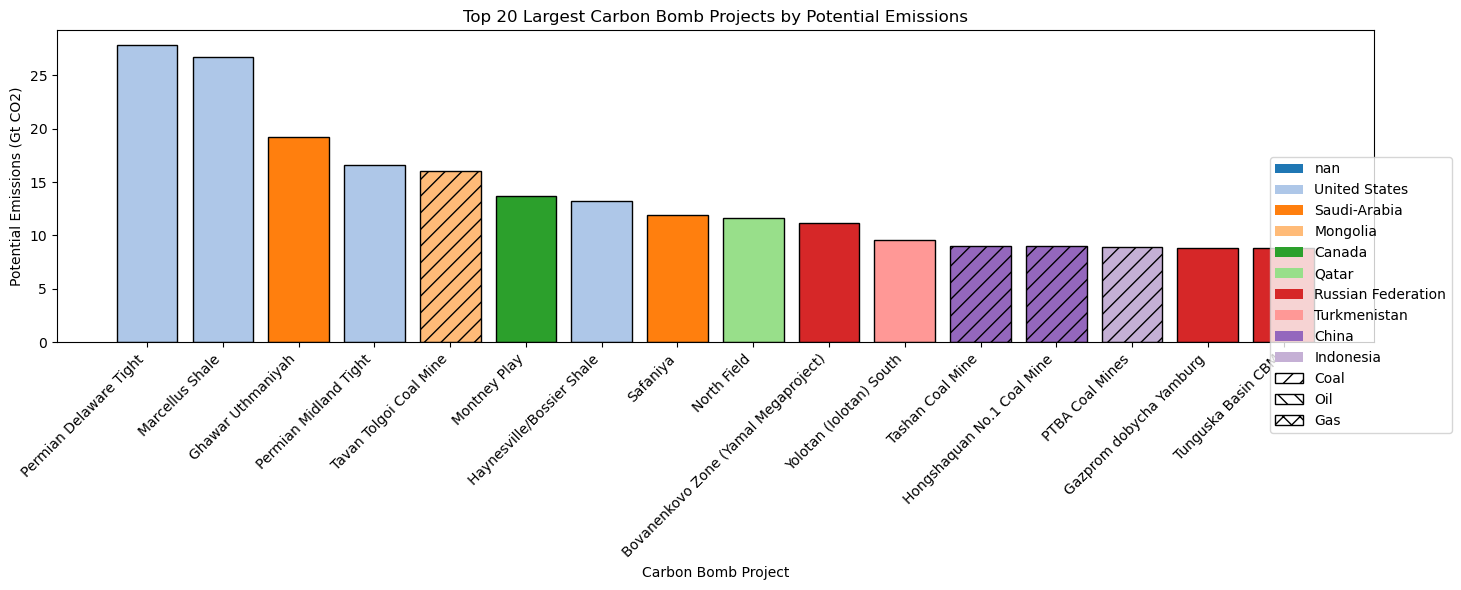

In [27]:
#4
import matplotlib.pyplot as plt

# Convert dataset to DataFrame
df_plot = ds.to_dataframe().reset_index()
top20 = df_plot.nlargest(20, 'potential_emissions')

# Colors for countries
countries = top20['country'].unique()
color_map = {country: color for country, color in zip(countries, plt.cm.tab20.colors)}

# Hatches for fuel
fuel_hatch = {'Coal': '//', 'Oil': '\\\\', 'Gas': 'xx'}

# Plot bars
fig, ax = plt.subplots(figsize=(14, 6))
bars = []

for i, row in top20.iterrows():
    bar = ax.bar(
        row['name'],
        row['potential_emissions'],
        color=color_map[row['country']],
        hatch=fuel_hatch.get(row['fuel'], ''),
        edgecolor='black'  # makes hatch visible
    )
    bars.append(bar)

ax.set_ylabel("Potential Emissions (Gt CO2)")
ax.set_xlabel("Carbon Bomb Project")
ax.set_title("Top 20 Largest Carbon Bomb Projects by Potential Emissions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Create **combined legend**
from matplotlib.patches import Patch

# Country legend (colors)
country_patches = [Patch(facecolor=color_map[c], label=c) for c in countries]

# Fuel legend (hatches)
fuel_patches = [Patch(facecolor='white', edgecolor='black', hatch=h, label=f) for f,h in fuel_hatch.items()]

# Add legend to figure
fig.legend(handles=country_patches + fuel_patches,
           bbox_to_anchor=(1.05, 0.5), loc='center right')

plt.show()

In [18]:
#task5
with open("ds_Carbon_Bombs_Permian_Delaware_Tight_all_hazards_all_regions.pkl", "rb") as f:
    ds_regions = pickle.load(f)

# Load the dataset by country
with open("ds_Carbon_Bombs_Permian_Delaware_Tight_all_hazards_all_countries.pkl", "rb") as f:
    ds_countries = pickle.load(f)
    print("Regions dataset:")
print(ds_regions)

print("\nCountries dataset:")
print(ds_countries)

Regions dataset:
<xarray.Dataset> Size: 41MB
Dimensions:                  (project: 1, extreme: 6, region: 12, samples: 70000)
Coordinates:
  * project                  (project) object 8B 'Permian Delaware Tight'
  * extreme                  (extreme) object 48B 'burntarea' ... 'tropicalcy...
  * region                   (region) object 96B 'East Asia & Pacific' ... 'W...
  * samples                  (samples) int64 560kB 0 1 2 3 ... 69997 69998 69999
Data variables: (12/13)
    S2S_LH_results           (project, extreme, region, samples) float64 40MB ...
    mean_val                 (project, extreme, region) float64 576B 1.884e+0...
    std_val                  (project, extreme, region) float64 576B 2.595e+0...
    median_val               (project, extreme, region) float64 576B 2.716e+0...
    ci_lower                 (project, extreme, region) float64 576B 0.0 ... 0.0
    ci_upper                 (project, extreme, region) float64 576B 7.321e+0...
    ...                       ..